In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')
mostafaabdlhamed_speech_signal_features_path = kagglehub.dataset_download('mostafaabdlhamed/speech-signal-features')

print('Data source import complete.')


Data source import complete.


In [4]:
# IMPORT LIBRARIES
import os
import sys
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Audio processing
import librosa
import librosa.display

# For playing audio files
import IPython.display as ipd
from IPython.display import Audio

# Sklearn utilities
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# TensorFlow / Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import (Dense, Embedding, LSTM, GRU,
                                     BatchNormalization, Input, Flatten,
                                     Dropout, Activation, Conv1D,
                                     MaxPooling1D, AveragePooling1D)

# Suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)
print("Setup complete")


TensorFlow version: 2.18.0
Setup complete


In [5]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,775 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,978 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,241 kB]
Get:12 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [70.9 kB]
Get:13 https://develo

# Importing Data

Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [6]:
#preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [7]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# preprocessing

**Ravdees**

In [8]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [9]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [10]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

<ipython-input-10-2e26f59c975e>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [11]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [12]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [13]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


**Integration**

In [14]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [15]:
print(data_path.Emotions.value_counts())


Emotions
disgust     1923
sad         1923
fear        1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

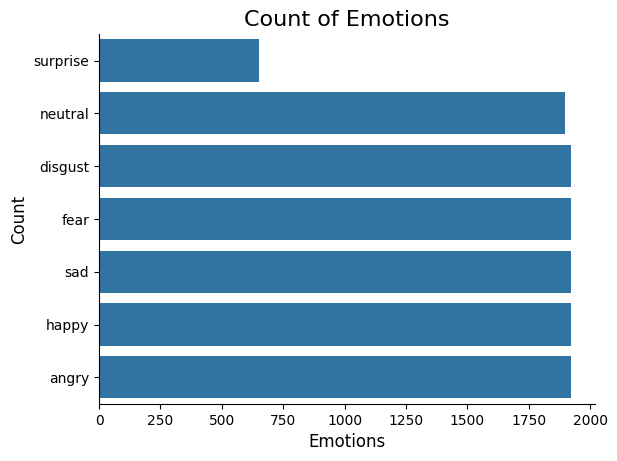

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [17]:
data,sr = librosa.load(file_path[0])
sr

22050

In [18]:
ipd.Audio(data,rate=sr)

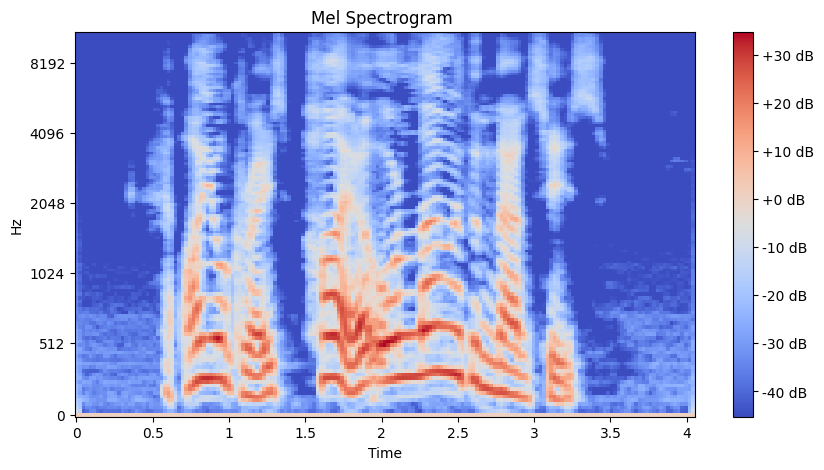

In [19]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

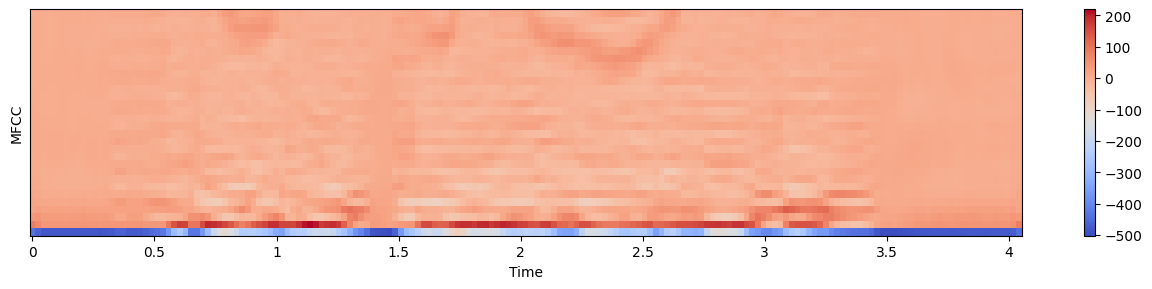

In [20]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [22]:
import numpy as np
import librosa

# Add random noise
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data_noised = data + noise_amp * np.random.normal(size=data.shape[0])
    return data_noised

# Time-stretch waveform correctly using STFT → phase vocoder → ISTFT
def stretch(data, rate=0.8):
    stft = librosa.stft(data)
    stretched_stft = librosa.phase_vocoder(stft, rate=rate)
    stretched_audio = librosa.istft(stretched_stft)
    return stretched_audio

# Random shift in time (wrap-around with np.roll)
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

# Pitch shifting using semitone steps
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)


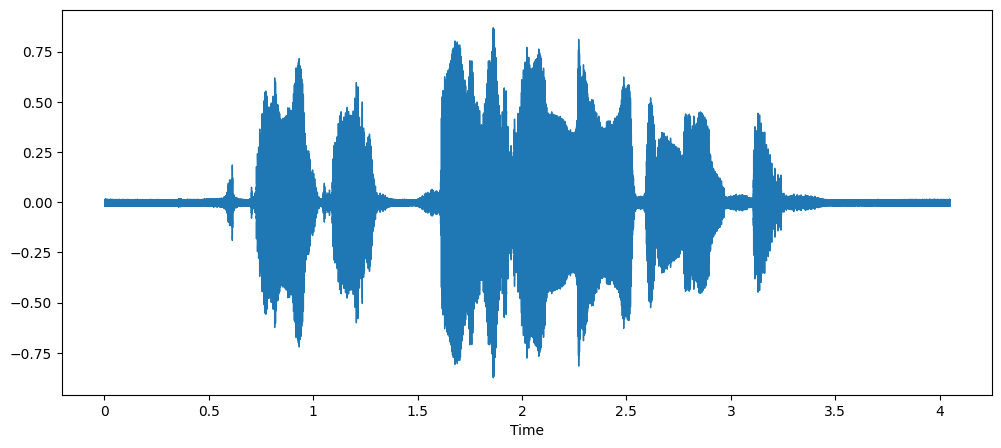

In [23]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

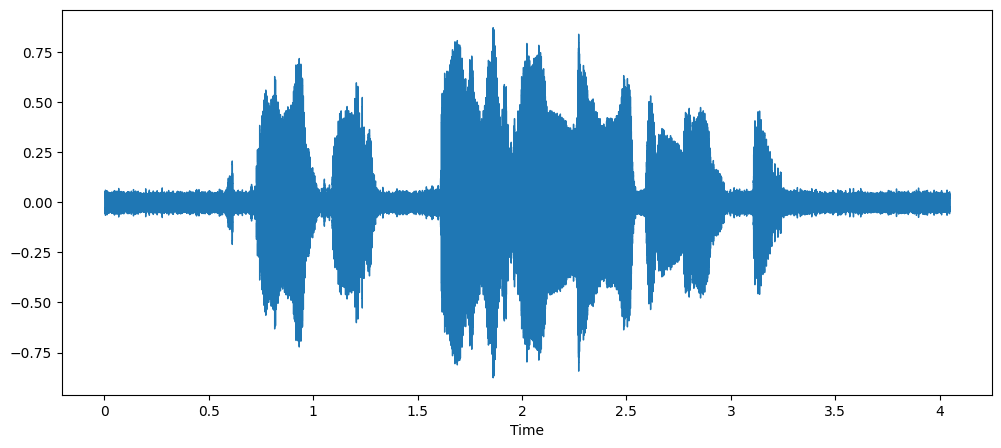

In [24]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

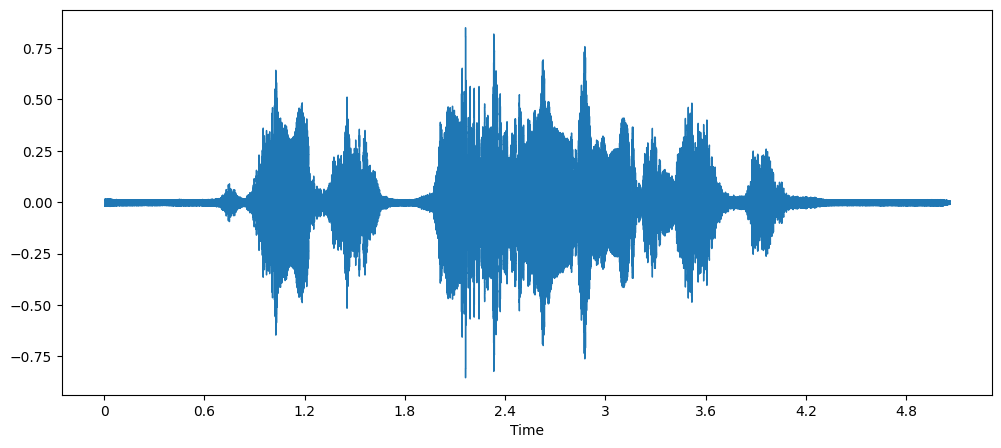

In [25]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

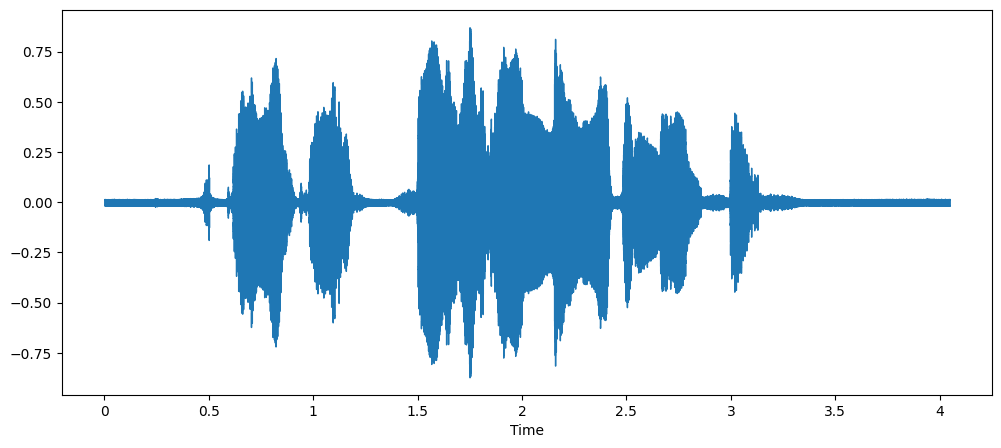

In [26]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

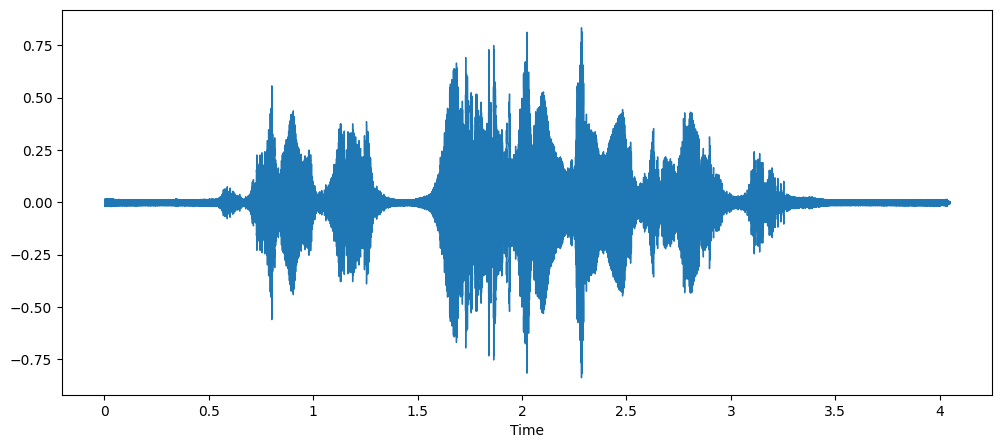

In [27]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [31]:
import librosa
import numpy as np

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# Root Mean Square Energy — FIXED (y=data)
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# MFCC Features
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

# Extract combined features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((
        result,
        zcr(data, frame_length, hop_length),
        rmse(data, frame_length, hop_length),
        mfcc(data, sr, frame_length, hop_length)
    ))
    return result


In [32]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


# Noraml way to get features

In [34]:
import timeit
from tqdm import tqdm
import os

# Optional: filter out broken paths
data_path = data_path[data_path['Path'].apply(os.path.exists)].reset_index(drop=True)

start = timeit.default_timer()
X, Y = [], []

print("Starting feature extraction...")

for path, emotion, index in tqdm(zip(data_path.Path, data_path.Emotions, range(data_path.shape[0])), total=data_path.shape[0]):
    try:
        features = get_features(path)
    except Exception as e:
        print(f"Skipped: {path} — Error: {e}")
        continue

    if index % 500 == 0:
        print(f'{index} audio files have been processed')

    for i in features:
        X.append(i)
        Y.append(emotion)

print("Done")

stop = timeit.default_timer()
print("Time: ", round(stop - start, 2), "seconds")


Starting feature extraction...


  0%|          | 2/12162 [00:00<16:50, 12.04it/s]

0 audio files have been processed


  4%|▍         | 501/12162 [00:56<29:08,  6.67it/s]

500 audio files have been processed


  8%|▊         | 1003/12162 [01:54<18:23, 10.11it/s]

1000 audio files have been processed


 12%|█▏        | 1502/12162 [02:48<13:35, 13.07it/s]

1500 audio files have been processed


 16%|█▋        | 2003/12162 [03:33<11:29, 14.73it/s]

2000 audio files have been processed


 21%|██        | 2504/12162 [04:16<11:44, 13.70it/s]

2500 audio files have been processed


 25%|██▍       | 3003/12162 [05:00<16:22,  9.32it/s]

3000 audio files have been processed


 29%|██▉       | 3504/12162 [05:42<10:28, 13.78it/s]

3500 audio files have been processed


 33%|███▎      | 4003/12162 [06:28<17:02,  7.98it/s]

4000 audio files have been processed


 37%|███▋      | 4502/12162 [07:11<09:26, 13.51it/s]

4500 audio files have been processed


 41%|████      | 5003/12162 [07:54<08:30, 14.03it/s]

5000 audio files have been processed


 45%|████▌     | 5502/12162 [08:38<08:05, 13.73it/s]

5500 audio files have been processed


 49%|████▉     | 6003/12162 [09:22<08:25, 12.19it/s]

6000 audio files have been processed


 53%|█████▎    | 6503/12162 [10:07<07:36, 12.40it/s]

6500 audio files have been processed


 58%|█████▊    | 7003/12162 [10:50<06:15, 13.74it/s]

7000 audio files have been processed


 62%|██████▏   | 7502/12162 [11:34<05:48, 13.36it/s]

7500 audio files have been processed


 66%|██████▌   | 8003/12162 [12:18<05:13, 13.26it/s]

8000 audio files have been processed


 70%|██████▉   | 8503/12162 [13:03<04:56, 12.33it/s]

8500 audio files have been processed


 74%|███████▍  | 9003/12162 [13:44<02:57, 17.80it/s]

9000 audio files have been processed


 78%|███████▊  | 9503/12162 [14:18<03:19, 13.32it/s]

9500 audio files have been processed


 82%|████████▏ | 10002/12162 [14:59<02:26, 14.75it/s]

10000 audio files have been processed


 86%|████████▋ | 10502/12162 [15:47<01:51, 14.94it/s]

10500 audio files have been processed


 90%|█████████ | 11003/12162 [16:26<01:16, 15.11it/s]

11000 audio files have been processed


 95%|█████████▍| 11504/12162 [17:06<00:44, 14.82it/s]

11500 audio files have been processed


 99%|█████████▊| 12001/12162 [17:54<00:14, 10.88it/s]

12000 audio files have been processed


100%|██████████| 12162/12162 [18:11<00:00, 11.14it/s]

Done
Time:  1091.99 seconds


# Faster way to get features
***Parallel way***

**Dont be afraid from red lines that Normal**


This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

*  The .extend() method increases the length of the list by the number of elements that are provided to the method, so if you want to add multiple elements to the list, you can use this method.

In [35]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  660.029874607


In [36]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

# Saving features

In [37]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.240723,0.355957,0.469727,0.465332,0.472656,0.486328,0.483887,0.488281,0.488770,0.486328,...,-3.510093,3.056149,3.662992,1.856550,0.148901,3.805658,0.895416,1.624532,4.377731,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518304,0.838670,1.308735,1.855114,2.405193,2.896440,3.283494,3.541683,3.667480,surprise
3,0.254395,0.371582,0.495117,0.492676,0.495605,0.498535,0.499023,0.497070,0.491211,0.488770,...,1.462028,1.893175,-1.290109,0.325552,-2.401066,-0.374927,2.563191,4.431967,5.890605,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [38]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.240723,0.355957,0.469727,0.465332,0.472656,0.486328,0.483887,0.488281,0.488770,0.486328,...,-3.510093,3.056149,3.662992,1.856550,0.148901,3.805658,0.895416,1.624532,4.377731,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518304,0.838670,1.308735,1.855114,2.405193,2.896440,3.283494,3.541683,3.667480,surprise
3,0.254395,0.371582,0.495117,0.492676,0.495605,0.498535,0.499023,0.497070,0.491211,0.488770,...,1.462028,1.893175,-1.290109,0.325552,-2.401066,-0.374927,2.563191,4.431967,5.890605,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [39]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [40]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [41]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


# Data preparation

In [42]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [43]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [44]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [45]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [46]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [47]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Embedding, LSTM, GRU, BatchNormalization,
                                     Input, Flatten, Dropout, Activation,
                                     Conv1D, MaxPooling1D, AveragePooling1D)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [50]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [52]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# LSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

In [53]:
model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(7,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 2376, 128)           │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2376, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 2376, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 856,967 (3.27 MB)

 Trainable params: 856,967 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist=model01.fit(X_train, y_train,
            epochs=3,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)

In [ ]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# CNN model

In [55]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [60]:
import tensorflow as tf
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Input(shape=(X_train.shape[1], 1)),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(7, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 2376, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 2376, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 1188, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 1188, 512)           │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 1188, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 594, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 594, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 297, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 297, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 149, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 149, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9600)                │              

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    x_traincnn,
    y_train,
    epochs=20,
    validation_data=(x_testcnn, y_test),
    batch_size=64,
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)

Epoch 1/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.3981 - loss: 1.6647
Epoch 1: val_accuracy improved from -inf to 0.44275, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 166s 252ms/step - accuracy: 0.3982 - loss: 1.6643 - val_accuracy: 0.4428 - val_loss: 1.4268 - learning_rate: 0.0010
Epoch 2/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5537 - loss: 1.1532
Epoch 2: val_accuracy improved from 0.44275 to 0.56557, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - accuracy: 0.5537 - loss: 1.1531 - val_accuracy: 0.5656 - val_loss: 1.1451 - learning_rate: 0.0010
Epoch 3/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6086 - loss: 1.0191
Epoch 3: val_accuracy improved from 0.56557 to 0.62343, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 141s 231ms/step - accuracy: 0.6086 - loss: 1.0191 - val_accuracy: 0.6234 - val_loss: 0.9781 - learning_rate: 0.0010
Epoch 4/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6620 - loss: 0.8855
Epoch 4: val_accuracy improved from 0.62343 to 0.62950, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.6620 - loss: 0.8855 - val_accuracy: 0.6295 - val_loss: 0.9652 - learning_rate: 0.0010
Epoch 5/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7138 - loss: 0.7618
Epoch 5: val_accuracy improved from 0.62950 to 0.66711, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 204s 238ms/step - accuracy: 0.7138 - loss: 0.7618 - val_accuracy: 0.6671 - val_loss: 0.9147 - learning_rate: 0.0010
Epoch 6/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7623 - loss: 0.6399
Epoch 6: val_accuracy improved from 0.66711 to 0.68047, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 200s 235ms/step - accuracy: 0.7623 - loss: 0.6398 - val_accuracy: 0.6805 - val_loss: 0.8814 - learning_rate: 0.0010
Epoch 7/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7499 - loss: 0.6655
Epoch 7: val_accuracy improved from 0.68047 to 0.77852, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 143s 234ms/step - accuracy: 0.7500 - loss: 0.6652 - val_accuracy: 0.7785 - val_loss: 0.6091 - learning_rate: 0.0010
Epoch 8/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8595 - loss: 0.3971
Epoch 8: val_accuracy did not improve from 0.77852
609/609 ━━━━━━━━━━━━━━━━━━━━ 200s 230ms/step - accuracy: 0.8595 - loss: 0.3970 - val_accuracy: 0.7419 - val_loss: 0.7391 - learning_rate: 0.0010
Epoch 9/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8219 - loss: 0.4882
Epoch 9: val_accuracy improved from 0.77852 to 0.82600, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - accuracy: 0.8220 - loss: 0.4878 - val_accuracy: 0.8260 - val_loss: 0.5014 - learning_rate: 0.0010
Epoch 10/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8747 - loss: 0.3571
Epoch 10: val_accuracy improved from 0.82600 to 0.87441, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 235ms/step - accuracy: 0.8748 - loss: 0.3568 - val_accuracy: 0.8744 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 11/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9444 - loss: 0.1673
Epoch 11: val_accuracy improved from 0.87441 to 0.90154, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 140s 230ms/step - accuracy: 0.9444 - loss: 0.1673 - val_accuracy: 0.9015 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 12/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9424 - loss: 0.1681
Epoch 12: val_accuracy improved from 0.90154 to 0.91778, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 239ms/step - accuracy: 0.9424 - loss: 0.1680 - val_accuracy: 0.9178 - val_loss: 0.2478 - learning_rate: 0.0010
Epoch 13/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9601 - loss: 0.1211
Epoch 13: val_accuracy did not improve from 0.91778
609/609 ━━━━━━━━━━━━━━━━━━━━ 197s 230ms/step - accuracy: 0.9601 - loss: 0.1211 - val_accuracy: 0.8717 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 14/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9500 - loss: 0.1441
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 14: val_accuracy did not improve from 0.91778
609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.9500 - loss: 0.1440 - val_accuracy: 0.9168 - val_loss: 0.2591 - learning_rate: 0.0010
Epoch 15/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9821 - loss: 0.0565
Epoch 15: val_accuracy improved from 0.91778 to 0.95570, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 140s 229ms/step - accuracy: 0.9821 - loss: 0.0565 - val_accuracy: 0.9557 - val_loss: 0.1423 - learning_rate: 1.0000e-04
Epoch 16/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9914 - loss: 0.0339
Epoch 16: val_accuracy improved from 0.95570 to 0.95982, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 235ms/step - accuracy: 0.9914 - loss: 0.0339 - val_accuracy: 0.9598 - val_loss: 0.1324 - learning_rate: 1.0000e-04
Epoch 17/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9946 - loss: 0.0253
Epoch 17: val_accuracy improved from 0.95982 to 0.96269, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 199s 230ms/step - accuracy: 0.9946 - loss: 0.0253 - val_accuracy: 0.9627 - val_loss: 0.1238 - learning_rate: 1.0000e-04
Epoch 18/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9960 - loss: 0.0203
Epoch 18: val_accuracy improved from 0.96269 to 0.96382, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - accuracy: 0.9960 - loss: 0.0203 - val_accuracy: 0.9638 - val_loss: 0.1201 - learning_rate: 1.0000e-04
Epoch 19/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9973 - loss: 0.0170
Epoch 19: val_accuracy improved from 0.96382 to 0.96650, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.9973 - loss: 0.0170 - val_accuracy: 0.9665 - val_loss: 0.1158 - learning_rate: 1.0000e-04
Epoch 20/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9972 - loss: 0.0145
Epoch 20: val_accuracy improved from 0.96650 to 0.96721, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 200s 230ms/step - accuracy: 0.9972 - loss: 0.0145 - val_accuracy: 0.9672 - val_loss: 0.1109 - learning_rate: 1.0000e-04


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9640 - loss: 0.1190
Accuracy of our model on test data :  96.7214822769165 %


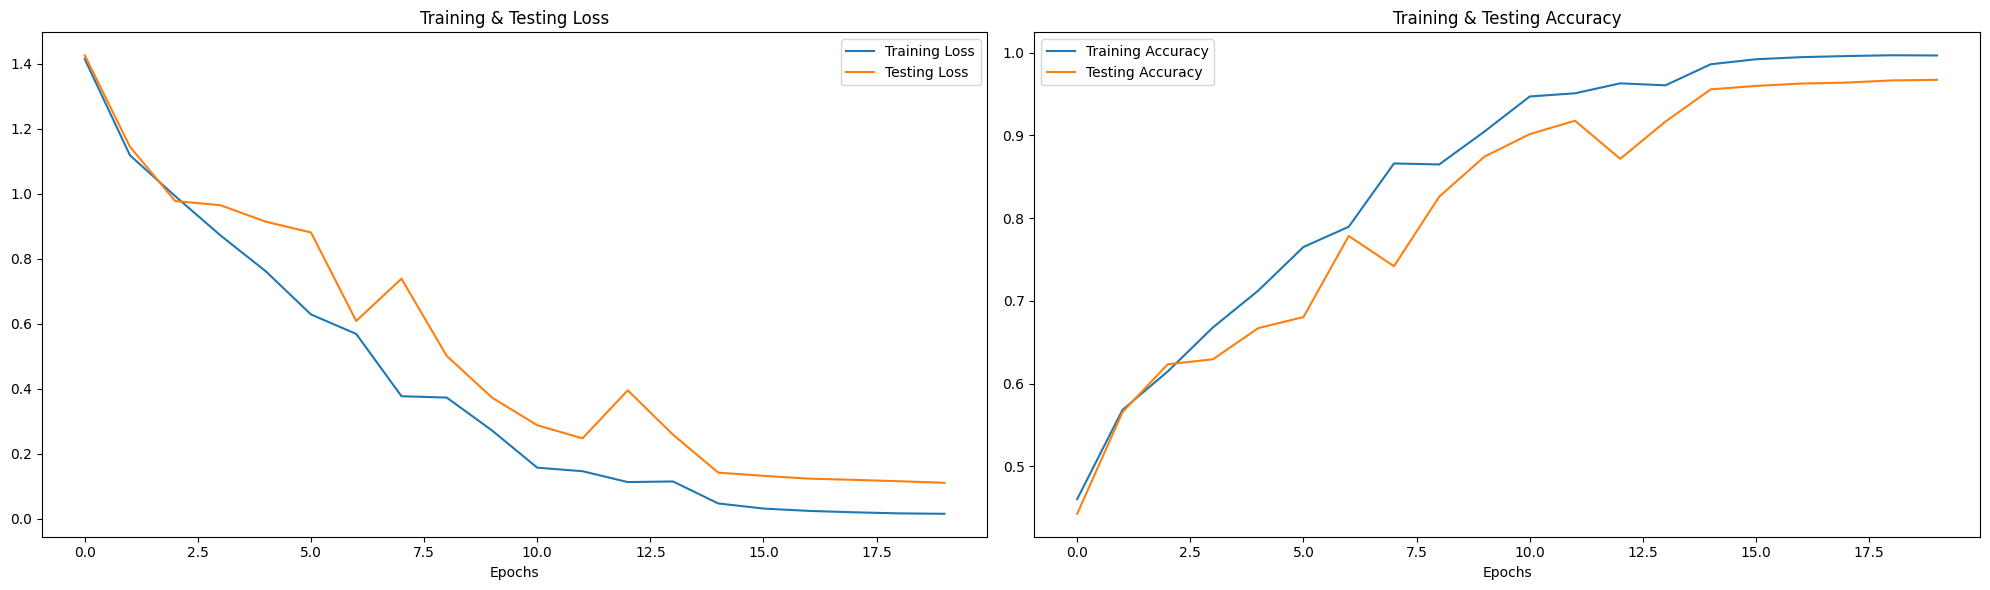

In [63]:
# Evaluate and print final test accuracy
print("Accuracy of our model on test data : ", model.evaluate(x_testcnn, y_test)[1] * 100, "%")

# Automatically match the number of actual training epochs
epochs = range(len(history.history['accuracy']))

# Extract history values
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Create side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot loss
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

# Plot accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

In [64]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,sad,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


In [65]:
df0

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,sad,disgust
3,happy,happy
4,fear,fear
...,...,...
9725,fear,fear
9726,disgust,disgust
9727,neutral,neutral
9728,sad,sad


Some plots of multi_model
______________________________________________


# CLSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

Another  model (CLSTM)  omnia model
_____________________________________________________

In [66]:
#Build the model

# define model
model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))


model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True))
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True))
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 2376, 1024)          │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 1188, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 1188, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1188, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 1188, 512)           │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 594, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 594, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 297, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 297, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 297, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 297, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 297, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,2

 Total params: 3,778,247 (14.41 MB)

 Trainable params: 3,774,663 (14.40 MB)

 Non-trainable params: 3,584 (14.00 KB)

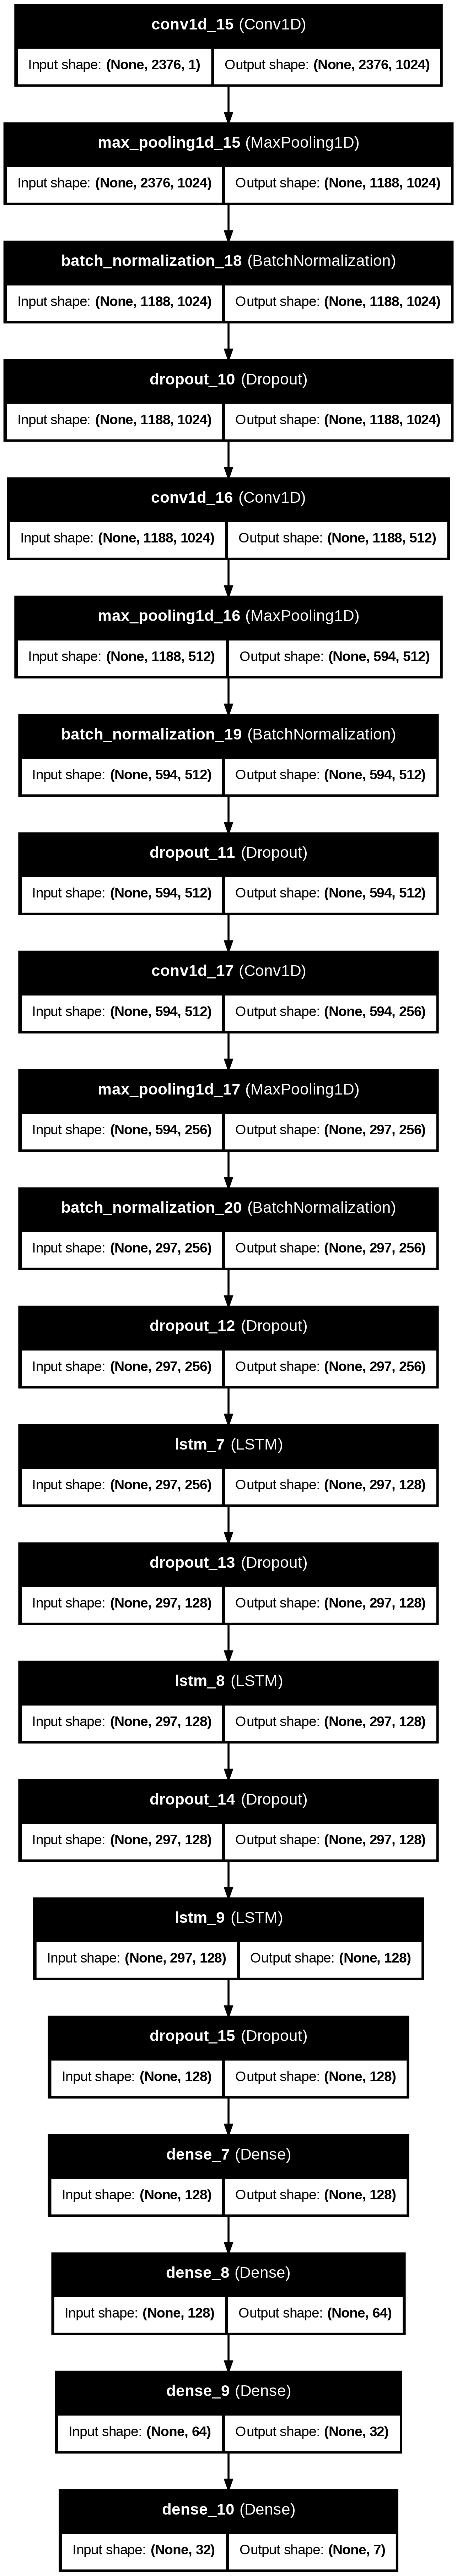

In [68]:
from tensorflow.keras.utils import plot_model
plot_model(model000, show_shapes=True, show_layer_names=True, to_file='model000.png')

In [69]:
model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
hist1=model000.fit(x_traincnn, y_train, batch_size=64, epochs=3, validation_data=(x_testcnn, y_test))

Epoch 1/3
609/609 ━━━━━━━━━━━━━━━━━━━━ 342s 529ms/step - accuracy: 0.1940 - loss: 1.8818 - val_accuracy: 0.2115 - val_loss: 1.8442
Epoch 2/3
609/609 ━━━━━━━━━━━━━━━━━━━━ 340s 558ms/step - accuracy: 0.2552 - loss: 1.7579 - val_accuracy: 0.3058 - val_loss: 1.6626
Epoch 3/3
609/609 ━━━━━━━━━━━━━━━━━━━━ 363s 527ms/step - accuracy: 0.3560 - loss: 1.5930 - val_accuracy: 0.4191 - val_loss: 1.4855


305/305 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4153 - loss: 1.4865
Accuracy of our model on test data :  41.91161394119263 %


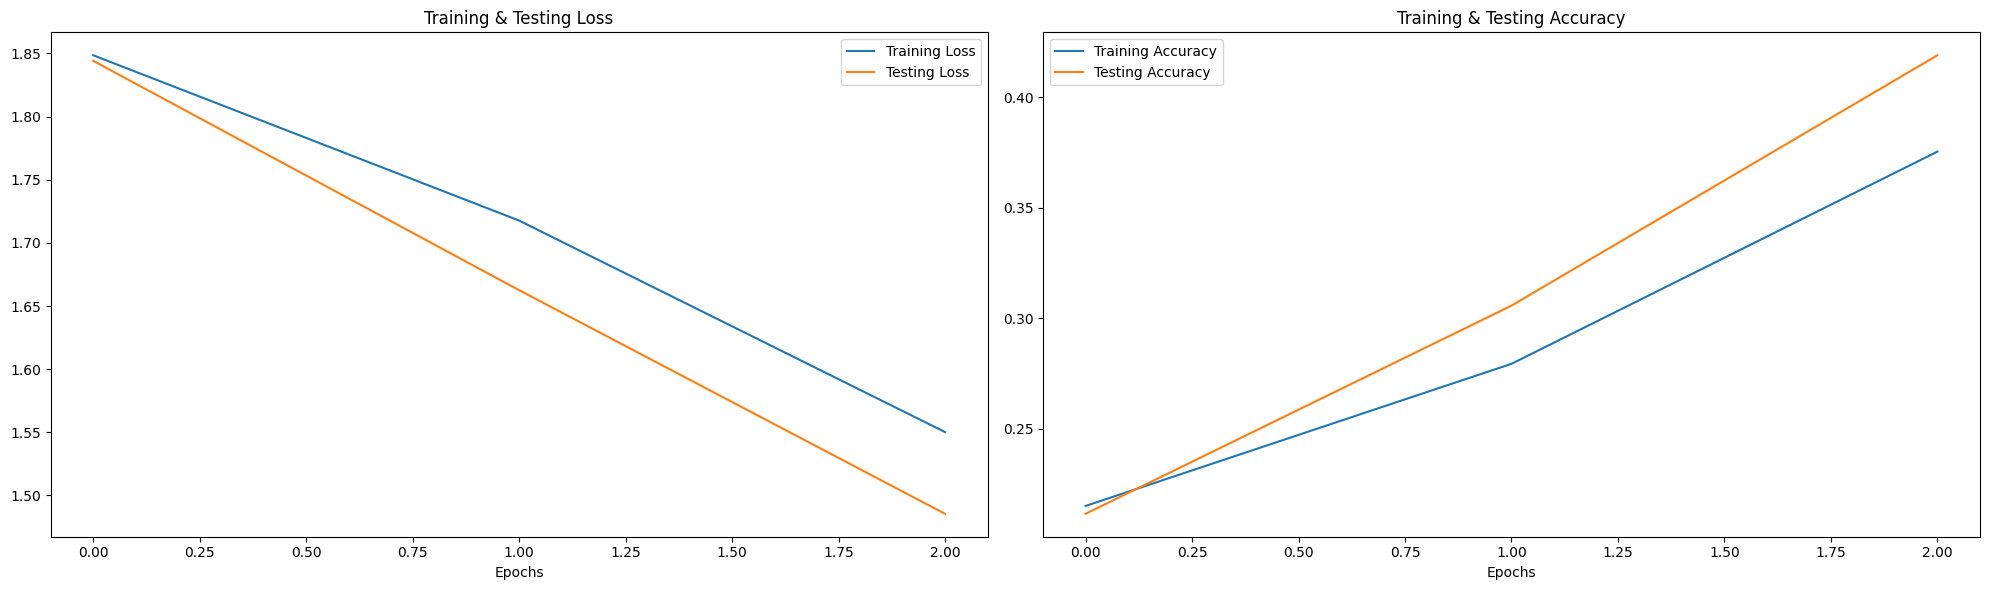

In [72]:
# Print final test accuracy
print("Accuracy of our model on test data : ", model000.evaluate(x_testcnn, y_test)[1] * 100, "%")

# Dynamically match the actual number of epochs
epochs = range(len(hist1.history['accuracy']))

# Extract metrics from training history
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Loss Plot
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

# Accuracy Plot
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

In [76]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

# Predict
pred_test00 = model000.predict(x_testcnn)

# Inverse transform directly on one-hot arrays
y_pred00 = encoder.inverse_transform(pred_test00)
y_test00 = encoder.inverse_transform(y_test)

# Create comparison DataFrame
df0 = pd.DataFrame({
    'Predicted Labels': y_pred00.flatten(),
    'Actual Labels': y_test00.flatten()
})

df0.head(10)


305/305 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,sad,disgust
3,angry,happy
4,neutral,fear
5,angry,happy
6,angry,happy
7,angry,fear
8,fear,fear
9,neutral,surprise


# Evalutation

Results of best model

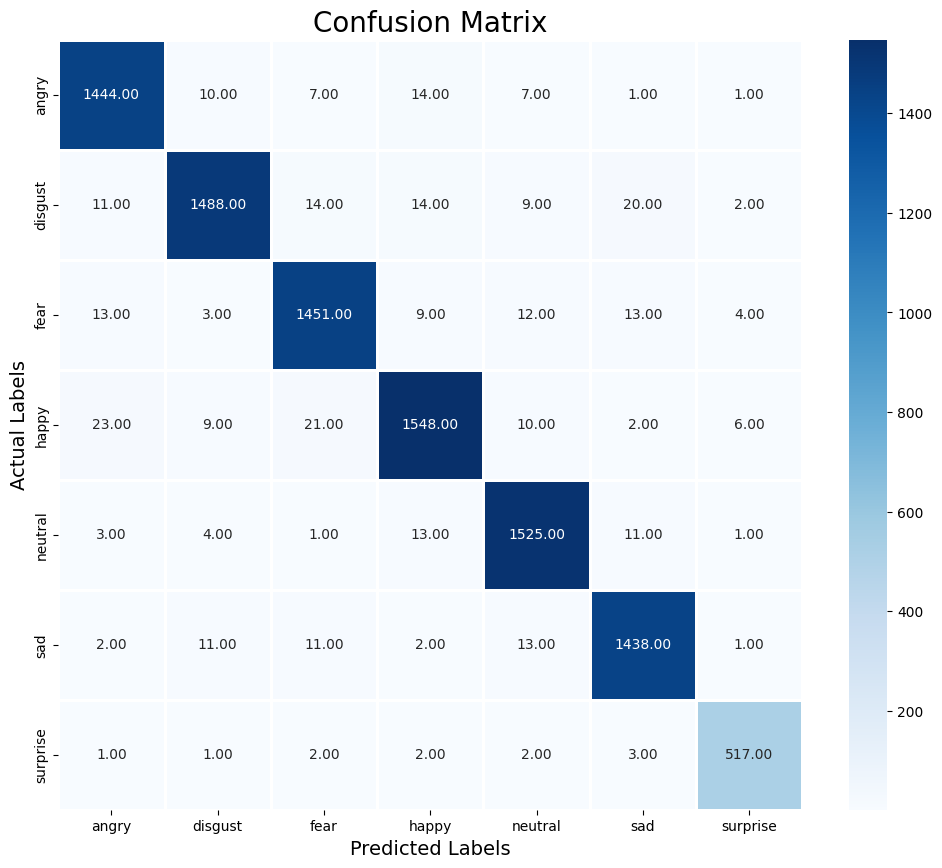

              precision    recall  f1-score   support

       angry       0.96      0.97      0.97      1484
     disgust       0.98      0.96      0.96      1558
        fear       0.96      0.96      0.96      1505
       happy       0.97      0.96      0.96      1619
     neutral       0.97      0.98      0.97      1558
         sad       0.97      0.97      0.97      1478
    surprise       0.97      0.98      0.98       528

    accuracy                           0.97      9730
   macro avg       0.97      0.97      0.97      9730
weighted avg       0.97      0.97      0.97      9730



In [77]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk")

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [ ]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

# Test script
* That can predict new record

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

In [ ]:
import pickle

with open('/kaggle/working/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/kaggle/working/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

In [ ]:
import librosa

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [ ]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [ ]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

In [ ]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")